<a href="https://colab.research.google.com/github/bemakerorg/AIoT_Book_RF/blob/main/AIoT_RF_Book_ES_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ESERCIZIO 16 - AUTOMOBILE O GATTO?**

In [1]:
# Importiamo la libreria TensorFlow per costruire e addestrare modelli di deep learning
import tensorflow as tf
# Importiamo il modulo tensorflow_datasets per accedere ai dataset preconfezionati
import tensorflow_datasets as tfds
# Importiamo matplotlib.pyplot per visualizzare grafici e immagini
import matplotlib.pyplot as plt
# Importiamo Sequential, un modello di rete neurale semplice da usare in Keras
from tensorflow.keras.models import Sequential
# Importiamo i vari strati necessari per costruire la rete neurale
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
# Importiamo l2 per applicare la regolarizzazione L2, che aiuta a prevenire l'overfitting
from tensorflow.keras.regularizers import l2
# Importiamo EarlyStopping, un callback per fermare l'addestramento se il modello smette di migliorare
from tensorflow.keras.callbacks import EarlyStopping
# Importiamo Adam, un algoritmo di ottimizzazione efficace usato comunemente nel deep learning
from tensorflow.keras.optimizers import Adam

In [2]:
# Carica il dataset CIFAR-10 da tensorflow_datasets
# split=['train', 'test'] separa il dataset in dati di addestramento e di test
# shuffle_files=True mescola i file per garantire che i dati siano randomizzati
# as_supervised=True restituisce le tuple (immagine, etichetta)
# with_info=True restituisce anche le informazioni sul dataset, come il numero di classi e la dimensione dell'immagine
(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

# Definisce una funzione per filtrare le immagini delle automobili nel dataset
def filter_automobiles(image, label):
    return tf.equal(label, 1)  # 1 è l'etichetta per 'automobile' nel dataset CIFAR-10

# Definisce una funzione per filtrare le immagini dei gatti nel dataset
def filter_cats(image, label):
    return tf.equal(label, 3)  # 3 è l'etichetta per 'gatto' nel dataset CIFAR-10

# Filtra il dataset di addestramento per ottenere solo le immagini delle automobili
train_ds_cars = train_ds.filter(filter_automobiles)

# Filtra il dataset di test per ottenere solo le immagini delle automobili
test_ds_cars = test_ds.filter(filter_automobiles)

# Filtra il dataset di addestramento per ottenere solo le immagini dei gatti
train_ds_cats = train_ds.filter(filter_cats)

# Filtra il dataset di test per ottenere solo le immagini dei gatti
test_ds_cats = test_ds.filter(filter_cats)

# Funzione per creare un dataset combinato di gatti e automobili
def create_combined_dataset(cat_ds, car_ds):
    # Cambia l'etichetta dei gatti in 0
    cat_ds = cat_ds.map(lambda image, label: (image, tf.constant(0, dtype=tf.int32)))

    # Cambia l'etichetta delle automobili in 1
    car_ds = car_ds.map(lambda image, label: (image, tf.constant(1, dtype=tf.int32)))

    # Concatenazione dei dataset di gatti e automobili
    combined_ds = cat_ds.concatenate(car_ds)

    # Mescola il dataset, imposta la dimensione del batch, normalizza le immagini dividendo i pixel per 255
    # Prefetching automatico per migliorare le prestazioni del training
    combined_ds = combined_ds.shuffle(10000).batch(32).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)
    return combined_ds

# Crea il dataset combinato di addestramento per gatti e automobili
train_ds_combined = create_combined_dataset(train_ds_cats, train_ds_cars)

# Crea il dataset combinato di test per gatti e automobili
test_ds_combined = create_combined_dataset(test_ds_cats, test_ds_cars)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.GJ8I6W_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.GJ8I6W_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
# Funzione per applicare tecniche di data augmentation alle immagini
def augment_data(image, label):
    # Esegue un flip casuale orizzontale sull'immagine
    image = tf.image.random_flip_left_right(image)

    # Modifica casualmente la luminosità dell'immagine, max_delta indica la variazione massima
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Modifica casualmente il contrasto dell'immagine, con valori compresi tra 0.9 e 1.1
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # Restituisce l'immagine modificata e la sua etichetta
    return image, label

# Applica la funzione di data augmentation al dataset combinato di addestramento
train_ds_combined = train_ds_combined.map(
    # Per ogni batch di immagini ed etichette, applica la funzione di data augmentation
    lambda x, y: (
        tf.map_fn(lambda img: augment_data(img, y)[0], x), # Applica augment_data a ciascuna immagine nel batch
        y # Mantiene le etichette invariate
    )
).prefetch(tf.data.AUTOTUNE) # Prefetching automatico per migliorare le prestazioni durante l'addestramento


In [4]:
# Definisce un modello di rete neurale convoluzionale (CNN) sequenziale
model = Sequential([
    # Strato di input che definisce la forma delle immagini in input: 32x32 pixel con 3 canali di colore (RGB)
    Input(shape=(32, 32, 3)),

    # Primo strato convoluzionale con 32 filtri 3x3, funzione di attivazione ReLU e regolarizzazione L2
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),

    # Strato di pooling che riduce la dimensionalità spaziale dell'input (downsampling) con una finestra 2x2
    MaxPooling2D((2, 2)),

    # Strato di dropout che disattiva casualmente il 25% dei neuroni per prevenire l'overfitting
    Dropout(0.25),

    # Secondo strato convoluzionale con 64 filtri 3x3, funzione di attivazione ReLU e regolarizzazione L2
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),

    # Strato di pooling che riduce la dimensionalità spaziale dell'input con una finestra 2x2
    MaxPooling2D((2, 2)),

    # Strato di dropout che disattiva casualmente il 25% dei neuroni per prevenire l'overfitting
    Dropout(0.25),

    # Terzo strato convoluzionale con 128 filtri 3x3, funzione di attivazione ReLU e regolarizzazione L2
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),

    # Strato di pooling che riduce la dimensionalità spaziale dell'input con una finestra 2x2
    MaxPooling2D((2, 2)),

    # Strato di Flatten che trasforma i dati 2D in un array 1D per collegarli agli strati densi
    Flatten(),

    # Strato denso (fully connected) con 128 neuroni, funzione di attivazione ReLU e regolarizzazione L2
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),

    # Strato di dropout che disattiva casualmente il 50% dei neuroni per prevenire l'overfitting
    Dropout(0.5),

    # Strato denso (fully connected) con 64 neuroni, funzione di attivazione ReLU e regolarizzazione L2
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),

    # Strato di dropout che disattiva casualmente il 50% dei neuroni per prevenire l'overfitting
    Dropout(0.5),

    # Strato denso finale con 2 neuroni (uno per ciascuna classe), funzione di attivazione softmax per classificazione
    Dense(2, activation='softmax')
])

# Compila il modello specificando l'algoritmo di ottimizzazione Adam con un tasso di apprendimento ridotto
# Utilizza 'sparse_categorical_crossentropy' come funzione di loss e 'accuracy' come metrica
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Stampa un riepilogo del modello, mostrando la struttura degli strati e i parametri di addestramento
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,298 (653.51 KB)

 Trainable params: 167,298 (653.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
    313/Unknown 34s 68ms/step - accuracy: 0.5912 - loss: 1.0595

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.5915 - loss: 1.0592 - val_accuracy: 0.7950 - val_loss: 0.8179
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.8403 - loss: 0.7253 - val_accuracy: 0.8285 - val_loss: 0.6920
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.8831 - loss: 0.6050 - val_accuracy: 0.9090 - val_loss: 0.5286
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9015 - loss: 0.5414 - val_accuracy: 0.9200 - val_loss: 0.4894
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9099 - loss: 0.4950 - val_accuracy: 0.9120 - val_loss: 0.4758
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.9137 - loss: 0.4637 - val_accuracy: 0.9180 - val_loss: 0.4403
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.9226 - loss: 0.4400 - val_accuracy: 0.9310 - val_loss: 0.4062
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.9255 - loss: 0.4120 - val_accurac

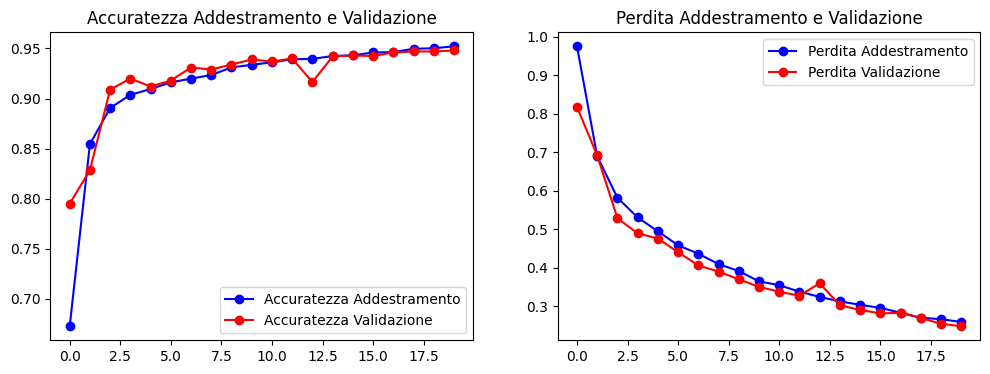

In [5]:
# Definisce un callback di early stopping per interrompere l'addestramento quando la performance del modello si stabilizza
# monitor='val_loss' monitora la perdita di validazione per determinare il momento di interrompere l'addestramento
# patience=3 consente al processo di addestramento di continuare per 3 epoche aggiuntive dopo l'ultima riduzione della perdita
# restore_best_weights=True ripristina i pesi del modello al miglior checkpoint di validazione raggiunto durante l'addestramento
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Addestra il modello utilizzando il dataset di addestramento combinato
# epochs=20 specifica il numero massimo di epoche di addestramento
# validation_data=test_ds_combined utilizza il dataset di test combinato per validazione durante l'addestramento
# callbacks=[early_stopping] applica il callback di early stopping per interrompere l'addestramento quando necessario
history = model.fit(train_ds_combined, epochs=20, validation_data=test_ds_combined, callbacks=[early_stopping])

# Valuta il modello sul dataset di test combinato
# Restituisce la perdita di test e l'accuratezza
test_loss, test_acc = model.evaluate(test_ds_combined)

# Stampa l'accuratezza di test
print(f'Test accuracy: {test_acc}')

# Definisce una funzione per tracciare i grafici della perdita e dell'accuratezza durante l'addestramento
def plot_history(history):
    # Estrae i dati di accuratezza e perdita dall'oggetto history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Crea un range di epoche per l'asse x
    epochs = range(len(acc))

    # Imposta le dimensioni della figura del grafico
    plt.figure(figsize=(12, 4))

    # Grafico dell'accuratezza di addestramento e validazione
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Accuratezza Addestramento')  # Linea blu per l'accuratezza di addestramento
    plt.plot(epochs, val_acc, 'ro-', label='Accuratezza Validazione')  # Linea rossa per l'accuratezza di validazione
    plt.title('Accuratezza Addestramento e Validazione')  # Titolo del grafico
    plt.legend()  # Mostra la legenda

    # Grafico della perdita di addestramento e validazione
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Perdita Addestramento')  # Linea blu per la perdita di addestramento
    plt.plot(epochs, val_loss, 'ro-', label='Perdita Validazione')  # Linea rossa per la perdita di validazione
    plt.title('Perdita Addestramento e Validazione')  # Titolo del grafico
    plt.legend()  # Mostra la legenda

    # Mostra i grafici
    plt.show()

# Chiama la funzione plot_history per stampare i grafici
plot_history(history)


Saving 000.jfif to 000.jfif
Saving 001.jfif to 001.jfif
Saving 003.jfif to 003.jfif
Saving 004.jfif to 004.jfif
Saving 006.jfif to 006.jfif
Saving auto_1.jfif to auto_1.jfif
Saving auto_1.jpg to auto_1.jpg
Saving auto_2.jfif to auto_2.jfif
Saving auto_2.jpg to auto_2.jpg
Saving gatto_01.webp to gatto_01.webp
Saving gatto_02.webp to gatto_02.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


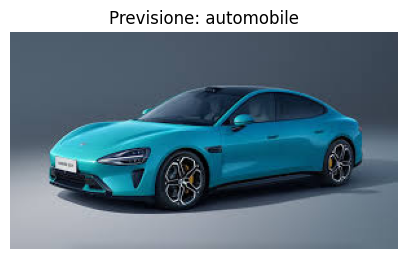

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


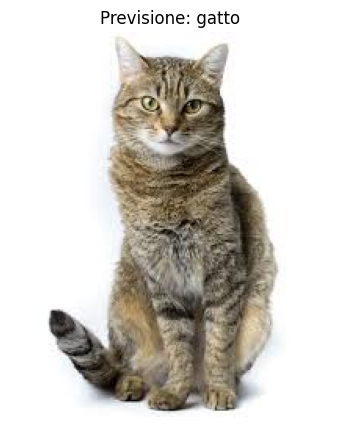

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


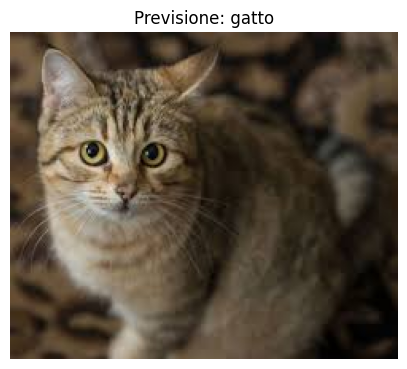

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


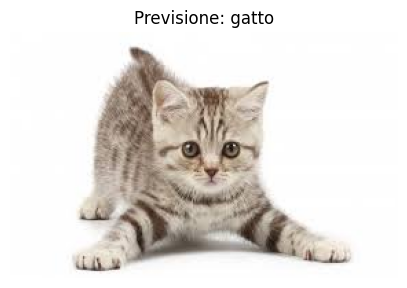

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


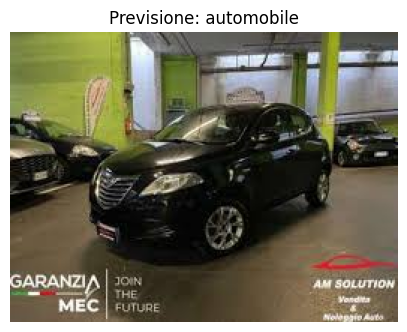

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


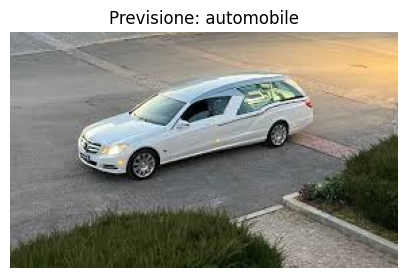

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


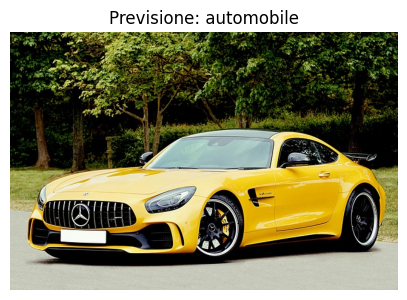

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


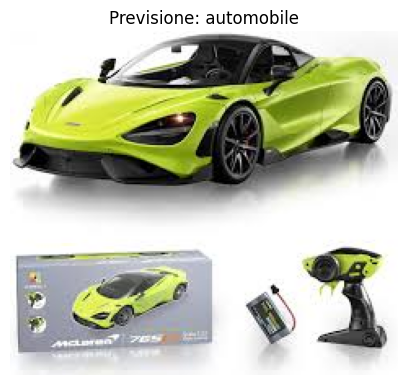

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


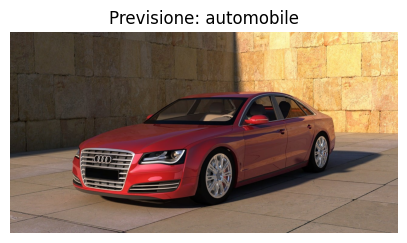

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


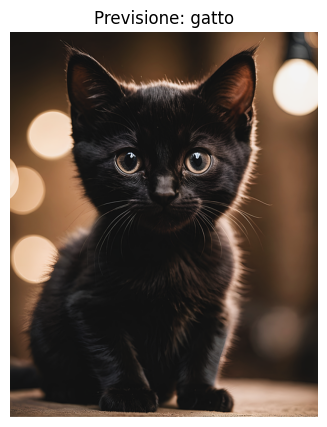

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


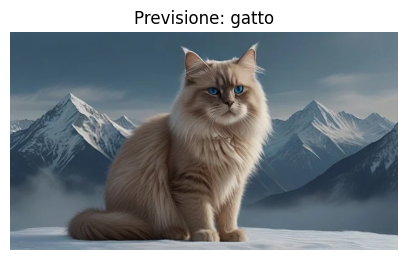

In [6]:
# Importa le librerie necessarie
from google.colab import files  # Per caricare file da locale in Google Colab
from tensorflow.keras.preprocessing import image  # Per la manipolazione delle immagini
import numpy as np  # Libreria per la manipolazione degli array
import matplotlib.pyplot as plt  # Libreria per la visualizzazione grafica

# Carica le immagini dal tuo PC
uploaded = files.upload()  # Utilizza un'interfaccia di caricamento file di Google Colab

# Funzione per preprocessare le immagini
def load_and_preprocess_image(image_path):
    # Carica l'immagine dal percorso specificato e ridimensionala a 32x32 pixel
    img = image.load_img(image_path, target_size=(32, 32))

    # Converti l'immagine in un array numpy (trasforma l'immagine in un array di pixel)
    img_array = image.img_to_array(img)

    # Normalizza l'immagine per avere valori dei pixel compresi tra 0 e 1
    img_array = img_array / 255.0

    # Aggiungi una dimensione per il batch, rendendo l'array (1, 32, 32, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Restituisce l'array dell'immagine preprocessata
    return img_array

# Funzione per visualizzare e predire le immagini caricate
def predict_and_display_images(uploaded_files):
    # Dizionario per mappare gli indici di classe a etichette umane comprensibili
    class_labels = {0: 'gatto', 1: 'automobile'}

    # Itera su ogni immagine caricata
    for image_path in uploaded_files:
        # Preprocessa l'immagine
        test_image = load_and_preprocess_image(image_path)

        # Fai la previsione utilizzando il modello già addestrato
        predictions = model.predict(test_image)

        # Ottieni l'indice della classe con la probabilità più alta
        predicted_class = np.argmax(predictions, axis=1)

        # Recupera l'etichetta corrispondente all'indice della classe predetta
        predicted_label = class_labels[predicted_class[0]]

        # Visualizza l'immagine e la sua previsione
        plt.figure(figsize=(5, 5))  # Imposta la dimensione della figura
        plt.imshow(image.load_img(image_path))  # Carica e mostra l'immagine originale
        plt.title(f"Previsione: {predicted_label}")  # Imposta il titolo della figura come la previsione
        plt.axis('off')  # Rimuove gli assi dalla visualizzazione
        plt.show()  # Mostra la figura

# Chiama la funzione per fare previsioni sulle immagini caricate
predict_and_display_images(uploaded.keys())
